# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.initializers import HeNormal

from scipy.stats import percentileofscore
import time
import math

# Training data

In [2]:
df = pd.read_parquet('poz-w-dataset-grid.parquet')
#df = pd.read_parquet('poz-w-dataset.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,time
0,-6753.15625,10778.15625,2727.515869,135.041199,2,66374,9115
1,2145.96875,4846.15625,4691.691406,3308.821289,1,73945,2292
2,11030.46875,-11807.50000,2723.373535,2488.457764,2,70073,7887
3,-3430.78125,-2428.37500,2339.359375,-1974.487549,0,50317,3194
4,9811.06250,-18968.84375,-2723.906982,1556.777344,1,40187,8026


In [3]:
print(df.size)

14000000


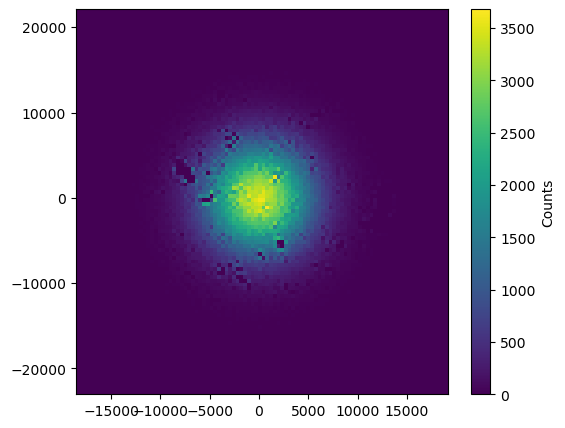

In [4]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [39]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Preprocessing

In [40]:
class CustomScalerLayer(Layer):
    def __init__(self, city_diameter=25000, **kwargs):
        super(CustomScalerLayer, self).__init__(**kwargs)
        self.city_diameter = city_diameter

    def call(self, inputs):
        # Normalize coordinates
        from_x = (inputs[:, 0] / self.city_diameter) + 0.5
        from_y = (inputs[:, 1] / self.city_diameter) + 0.5
        to_x = (inputs[:, 2] / self.city_diameter) + 0.5
        to_y = (inputs[:, 3] / self.city_diameter) + 0.5
        
        # Normalize start time
        start = inputs[:, 5] / 86400.0  # 86400 seconds in a day
        
        # Combine normalized features
        normalized_inputs = tf.stack([from_x, from_y, to_x, to_y, inputs[:, 4], start], axis=1)
        return normalized_inputs

In [41]:
scaler_layer = CustomScalerLayer()

# Model definition

## architecture

In [42]:
model = Sequential([
    scaler_layer,
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    #Dense(64, activation='relu', kernel_initializer=HeNormal(),input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(16, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential')
    #Dense(1, activation='softplus')
])

## loss function

In [43]:
def asymetric_loss_function(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tf.debugging.assert_greater(
        tf.reduce_min(y_true), tf.constant(0.0, dtype=tf.float32),
        message="y_true contains zero or negative values!"
    )
    
    ratio = y_pred / (y_true * 0.9)
    
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    )
    loss = tf.where(ratio <= 1, (1-ratio)**2, 7* tf.math.log(ratio))
    
    return tf.reduce_mean(loss)

## compile

In [44]:
model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

# Training

In [45]:
history = model.fit(X_train, y_train, epochs=8, batch_size=16, validation_split=0.2)

Epoch 1/8
 2013/80000 [..............................] - ETA: 4:01 - loss: 0.7480 - mape: 81.7926

KeyboardInterrupt: 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp46lrt5vc\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp46lrt5vc\assets


ConverterError: c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: 'tf.Cast' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: note: Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: Cast
Details:
	tf.Cast(tensor<?x6xf64>) -> (tensor<?x6xf32>) : {Truncate = false, device = ""}



# Model evaluation

## Read tflite model

In [47]:
with open('model.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## predicitons on test set

In [57]:
y_pred = []

for i in range(X_test.shape[0]):
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    #single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 0.76%


## Visualize set results distribution

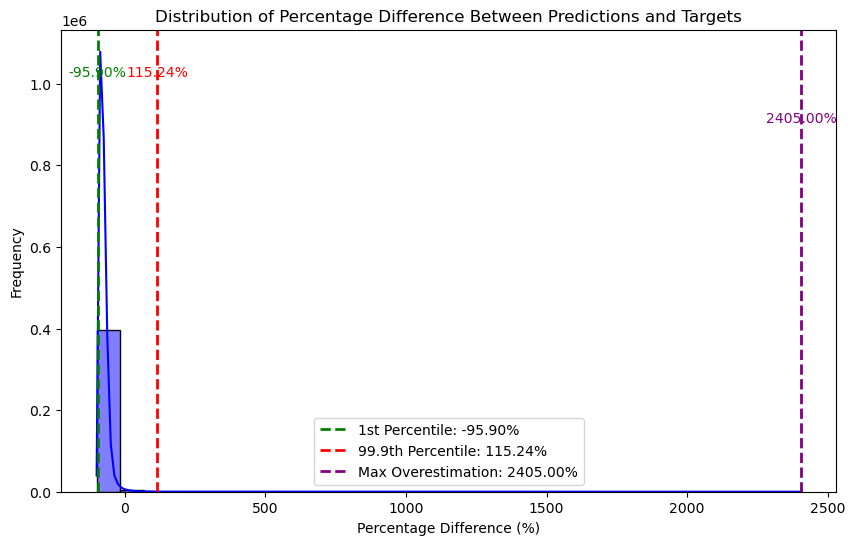

Maximal Overestimation Value: 2405.00%
Percentile for 0 on x-axis value: 99.31%


In [58]:
percentage_difference = ((y_pred - y_test) / y_test) * 100

percentile_1 = np.percentile(percentage_difference, 1)
percentile_99 = np.percentile(percentage_difference, 99.9)
max_overestimation = np.max(percentage_difference)
percentile_of_0 = percentileofscore(percentage_difference, 0)

plt.figure(figsize=(10, 6))
sns.histplot(percentage_difference, kde=True, bins=30, color='blue')

plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Difference Between Predictions and Targets')
plt.legend()
plt.show()

print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

## Forward pass time

In [59]:
y_pred = []

for i in range(X_test.shape[0]):
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    #single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(output_data[0][0])

y_pred = np.array(y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Test MAPE using TensorFlow Lite: {test_mape}')

# Print a few predictions
for pred, actual in zip(y_pred[:5], y_test[:5]):
    print(f'Predicted: {pred:.4f}, Actual: {actual:.4f}')

Test MAPE using TensorFlow Lite: 0.7612197713705925
Predicted: 1222.0743, Actual: 4043.0000
Predicted: 475.0011, Actual: 2821.0000
Predicted: 410.4487, Actual: 7403.0000
Predicted: 827.2053, Actual: 4357.0000
Predicted: 1733.9735, Actual: 8000.0000


In [61]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test.shape[0])
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    #single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.time()
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 20.474315 microseconds
total time for 10000 rows: 204.7431468963623 milliseconds
